In [1]:
import os
from itertools import islice

import numpy as np
import pandas as pd

from skimage.external import tifffile
from scipy.ndimage import gaussian_filter
from skimage.external.tifffile import imread
from scipy.ndimage.measurements import center_of_mass
from scipy.ndimage.morphology import binary_erosion as br
from skimage import morphology as skmor

import ipywidgets as widgets

from scipy import ndimage
from PIL import Image, ImageDraw

import numpy.ma as ma

from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

In [2]:
bigDir = r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading\DATA'

In [3]:
myFile= r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading\sel_cells_20_50_10_newctrl.csv'

In [4]:
myBigData=pd.read_csv(myFile)

In [5]:
myBigData.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,file,original cell name,Amy_mod,movie,x,y,...,random_10perc_ch1,hetChrom_10perc_ch2,random_10perc_ch2,hetChrom_10perc_ch3,random_10perc_ch3,exp_folder,hetChrom_newctl_volume,hetChrom_newctl_ch1,hetChrom_newctl_ch2,hetChrom_newctl_ch3
0,0,0,0,0,20190625_cell-00.czi,7LE1(B),1130/10,190619-cdc6-dhb-pcna002xy09,172,956,...,281528813.0,174067475.0,131640512.0,1.352231e+09,1.043517e+09,20190625-MSL rename,280370,5.739116e+09,3.726297e+09,9.123801e+09
1,1,1,1,1,20190625_cell-01.czi,7L-E1(T),0,190619-cdc6-dhb-pcna002xy09,158,906,...,266516067.0,162411790.0,128299406.0,1.353023e+09,1.065184e+09,20190625-MSL rename,250606,5.403750e+09,3.628343e+09,8.997863e+09
2,2,2,2,2,20190625_cell-02.czi,7L-E2(B),0,190619-cdc6-dhb-pcna002xy09,832,252,...,318905411.0,194622718.0,148176740.0,1.366670e+09,1.118365e+09,20190625-MSL rename,189925,6.729417e+09,4.442309e+09,1.076495e+10
3,3,3,3,3,20190625_cell-03.czi,7L-E2(T),0,190619-cdc6-dhb-pcna002xy09,888,160,...,285348983.0,195376713.0,139563277.0,1.298882e+09,1.038559e+09,20190625-MSL rename,220076,5.459073e+09,3.733122e+09,9.257708e+09
4,4,4,4,4,20190625_cell-05.czi,7L-G2,0,190619-cdc6-dhb-pcna002xy09,172,324,...,698512214.0,248463390.0,183210463.0,2.583220e+09,2.158853e+09,20190625-MSL rename,436430,8.007695e+09,4.024894e+09,1.674243e+10



# creating new filter (structure) for erosion

In [6]:
new_filter=skmor.ball(1)
radius=1
while (new_filter.shape[0]<7):
    radius+=1
    new_filter=skmor.ball(radius)
    print(radius)
new_filter=np.delete(new_filter, [(0,1,5,6)], axis=0)

nine_filter=skmor.ball(1)
radius=1
while (nine_filter.shape[0]<9):
    radius+=1
    nine_filter=skmor.ball(radius)
    print(radius)
nine_filter=np.delete(nine_filter, [(0,1,2,6,7,8)], axis=0)

elv_filter=skmor.ball(1)
radius=1
while (elv_filter.shape[0]<11):
    radius+=1
    elv_filter=skmor.ball(radius)
    print(radius)
elv_filter=np.delete(elv_filter, [(0,1,2,7,8,9,10)], axis=0)

2
3
2
3
4
2
3
4
5


In [11]:
thr_filter=skmor.ball(1)
radius=1
while (elv_filter.shape[0]<13):
    radius+=1
    elv_filter=skmor.ball(radius)
    print(radius)
elv_filter=np.delete(elv_filter, [(0,1,2,3,4,8,9,10,11,12)], axis=0)

2
3
4
5
6


<IPython.core.display.Javascript object>


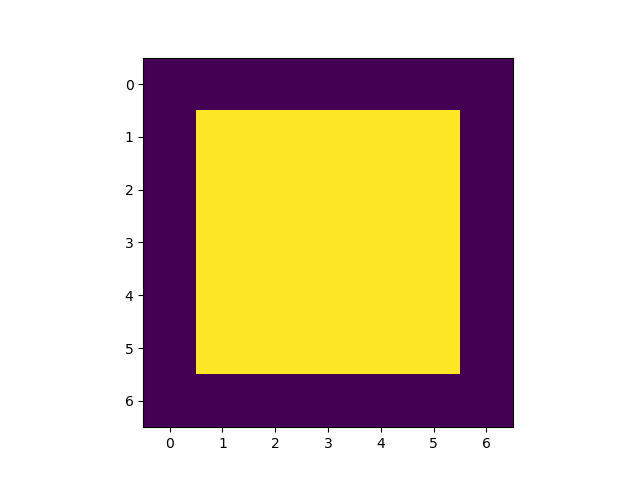

In [8]:
%matplotlib notebook
plt.imshow(new_filter[2])

In [52]:
df=pd.DataFrame(columns=['9x9','13x13','org','9^3','13^5', '13^8'])

# trying scipy.ndimage.morphology.binary_erosion with new filter

In [59]:
for i, cell in myBigData.iterrows():
    percentile = 20

    # open tiff image of a cell
    myImage=imread(cell.path)    
    myChannel = myImage[:, 0, :, :] #1st channel is hetChrom (as stained by HP1B or H3K9Me3)
    myNucChannel = myImage[:,2,:,:]
    # open nucleus mask
    nucleusMaskPath=cell.path
    nucleusMaskPath=nucleusMaskPath.replace('data_tiff','segmentation_nucleus_Otsu')
    nucleusMaskPath=nucleusMaskPath.replace('.tif','_nucleus.tif')
    nucMask=imread(nucleusMaskPath)
    nucMask=nucMask.astype(bool)

    # open het mask - new control
    myHetMaskPath=cell.path
    myHetMaskPath=myHetMaskPath.replace('data_tiff',f'segmentation_{percentile}')
    myHetMaskPath=myHetMaskPath.replace('.tif','_hetChrom.tif')
    het=imread(myHetMaskPath)
    het=het.astype(bool)
        
    nucMask[nucMask==255]=1
    
    copy_nuc=nucMask.copy()
    nin=br(nucMask, structure=nine_filter)
    thr=br(nucMask, structure=thr_filter)
    
    nin_thr=br(nucMask, structure=nine_filter, iterations=3)
    thr_fiv=br(nucMask, structure=thr_filter, iterations=5)
    nin_fiv=br(nucMask, structure=nine_filter, iterations=5)
    thr_sev=br(nucMask, structure=thr_filter, iterations=8)


    '''
    df.at[i,'9x9']=np.sum(nin)
    df.at[i,'13x13']=np.sum(thr)
    df.at[i,'org']=np.sum(nucMask)
    df.at[i,'9^3']=np.sum(nin_thr)
    df.at[i,'13^5']=np.sum(thr_fiv)
    df.at[i,'9^5']=np.sum(nin_fiv)
    df.at[i,'13^8']=np.sum(thr_sev)
    '''

    nin_thr=nin_thr.astype(bool)
    nin_thr_erode=het[nin_thr]
    test_eroded=ma.zeros(het.shape)
    test_eroded[nin_thr]=nin_thr_erode
    
    
    
    newSegFolder = os.path.dirname(cell.path).replace('data_tiff','sphere_v2_erosion')

    try:
        os.mkdir(newSegFolder)
    except:
        pass
    
    
    
    
    '''
    maskFile = os.path.basename(cell.path).replace('.tif',f'_erosion_9^3_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), nin_thr.astype('uint8'))
    
    maskFile = os.path.basename(cell.path).replace('.tif',f'_erosion_9^5_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), nin_fiv.astype('uint8'))
    
    maskFile = os.path.basename(cell.path).replace('.tif',f'_erosion_13^5_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), thr_fiv.astype('uint8'))
    
    maskFile = os.path.basename(cell.path).replace('.tif',f'_erosion_13^8_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), thr_sev.astype('uint8'))
    
    maskFile = os.path.basename(cell.path).replace('.tif',f'_erosion_9x9_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), nin.astype('uint8'))
    
    
    maskFile = os.path.basename(cell.path).replace('.tif',f'_erosion_7x7_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), sev.astype('uint8'))
    
    maskFile = os.path.basename(cell.path).replace('.tif',f'_erosion_11x11_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), elv.astype('uint8'))
    '''   
    
    
    

KeyboardInterrupt: 

In [ ]:
%matplotlib notebook
plt.imshow(test_eroded[20])

In [54]:
df.head()

,9x9,13x13,org,9^3,13^5,13^8,9^5
0,372904.0,411032,459898,228601,228977,108435,121203.0
1,351904.0,392498,436537,212980,229316,120724,113058.0
2,322818.0,359793,397040,200700,221352,129190,110924.0
3,340963.0,380509,421628,208701,228705,128365,112322.0
4,683392.0,743668,814272,458946,477692,296285,283573.0


In [55]:
np.mean(df['9^3']/df['org'])

0.48286970083637487

In [56]:
np.mean(df['13^5']/df['org'])

0.46889576797693205

In [57]:
np.mean(df['13^8']/df['org'])

0.20802783132625308

In [58]:
np.mean(df['9^5']/df['org'])

0.24654992139390458

In [70]:
df.head()

,7x7,9x9,11x11,org
0,383196,372904,342033,459898
1,362672,351904,322759,436537
2,332619,322818,297828,397040
3,351452,340963,313556,421628
4,699401,683392,636876,814272


In [71]:
np.mean(df['11x11']/df['org'])

0.7354589498976032

In [72]:
np.mean(df['9x9']/df['org'])

0.8054552657212094

In [73]:
np.mean(df['7x7']/df['org'])

0.8270571053944847

In [61]:
np.sum(test_br)

383196

In [56]:
np.sum(nucMask)

459898

<IPython.core.display.Javascript object>


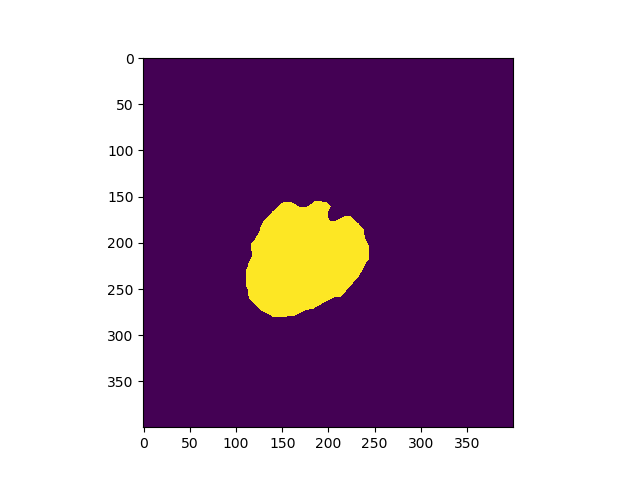

In [30]:
%matplotlib notebook
plt.imshow(test_br[30])

<IPython.core.display.Javascript object>


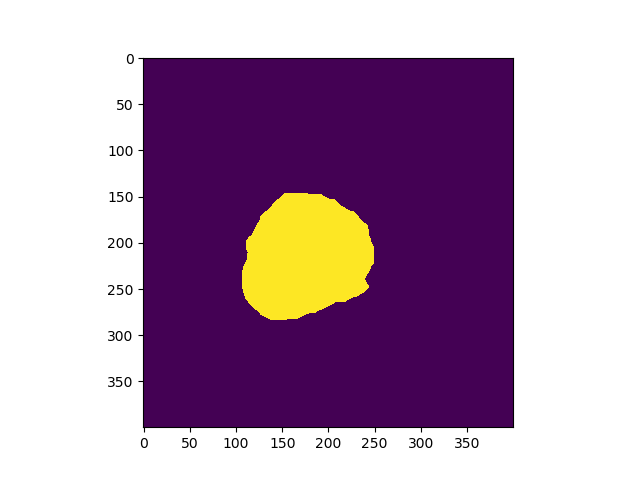

In [24]:
%matplotlib notebook
plt.imshow(nucMask[30])

In [20]:
new_filter=skmor.ball(1)
radius=1
while (new_filter.shape[0]<11):
    radius+=1
    new_filter=skmor.ball(radius)
    print(radius)

2
3
4
5


In [21]:
test_fil=np.delete(new_filter, [(0,1,2,7,8,9,10)], axis=0)

In [18]:
nucMask.shape

(45, 400, 400)